In [1]:
import  numpy as np
import matplotlib as plt

In [2]:
from qiskit import BasicAer, Aer, IBMQ
from qiskit import QuantumRegister ,ClassicalRegister,QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.aqua.operators import I, X, Y, Z

from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.components.optimizers import COBYLA

from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

In [19]:
#jut a dirty trick
from scipy.optimize import minimize
from tools import decompose, expected
from tools import ansatz_cell,var_circ
from tools import value, cost

In [5]:
backend=Aer.get_backend('qasm_simulator')

In [6]:
basis='sto3g'
inter_dist=1.4
# Molecule
atoms = 'Li .0 .0 .0; H .0 .0 '+str(inter_dist)
driver = PySCFDriver(atoms, unit=UnitsType.ANGSTROM, charge=0, spin=0, basis=basis,max_memory=None)

#integral h_{lm} , h_{lmpq}
molecule = driver.run()
h1 = molecule.one_body_integrals
h2 = molecule.two_body_integrals
nuclear_repulsion_energy = molecule.nuclear_repulsion_energy

num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2
print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
print("# nr. of electrons: {}".format(num_particles))
print("# nr. of spin orbitals: {}".format(num_spin_orbitals))
#print('# one elctron integral:\n',h1)
#print('# two elctron integral:\n',h2)

HF energy: -8.994489827277834
# nr. of electrons: 4
# nr. of spin orbitals: 12


In [7]:
ferOp = FermionicOperator(h1=h1, h2=h2)
qubitOp = ferOp.mapping(map_type='jordan_wigner')

In [8]:
print(qubitOp)
print(qubitOp.print_details())

weight=[]
pauli=[]
for w,i in qubitOp._paulis:
    weight.append(w)
    pauli.append(i.to_label())

Representation: paulis, qubits: 12, size: 631
IIIIIIIIIIII	(-5.204548018354729+0j)
IIIIIIIIIIIZ	(1.0166862076202912+0j)
IIIIIIIIIIYY	(0.01630003102619786+0j)
IIIIIIIIIIXX	(0.01630003102619786+0j)
IIIIIIIIIYZY	(0.02616572101236934+0j)
IIIIIIIIIXZX	(0.02616572101236934+0j)
IIIIIIYZZZZY	(0.001993581496571051+0j)
IIIIIIXZZZZX	(0.001993581496571051+0j)
IIIIIIIIIIZI	(-0.110811256145883+0j)
IIIIIIIIIYYI	(-0.007920752335708582+0j)
IIIIIIIIIXXI	(-0.007920752335708582+0j)
IIIIIIYZZZYI	(0.006544333829357514+0j)
IIIIIIXZZZXI	(0.006544333829357514+0j)
IIIIIIIIIZII	(-0.19609840978477958+0j)
IIIIIIYZZYII	(0.014431153839343937+0j)
IIIIIIXZZXII	(0.014431153839343937+0j)
IIIIIIIIZIII	(-0.22677467146771613+0j)
IIIIIIIZIIII	(-0.22677467146771613+0j)
IIIIIIZIIIII	(-0.4093492965506177+0j)
IIIIIZIIIIII	(1.016686207620291+0j)
IIIIYYIIIIII	(0.016300031026197842+0j)
IIIIXXIIIIII	(0.016300031026197842+0j)
IIIYZYIIIIII	(0.026165721012369355+0j)
IIIXZXIIIIII	(0.026165721012369355+0j)
YZZZZYIIIIII	(0.00199358149657

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


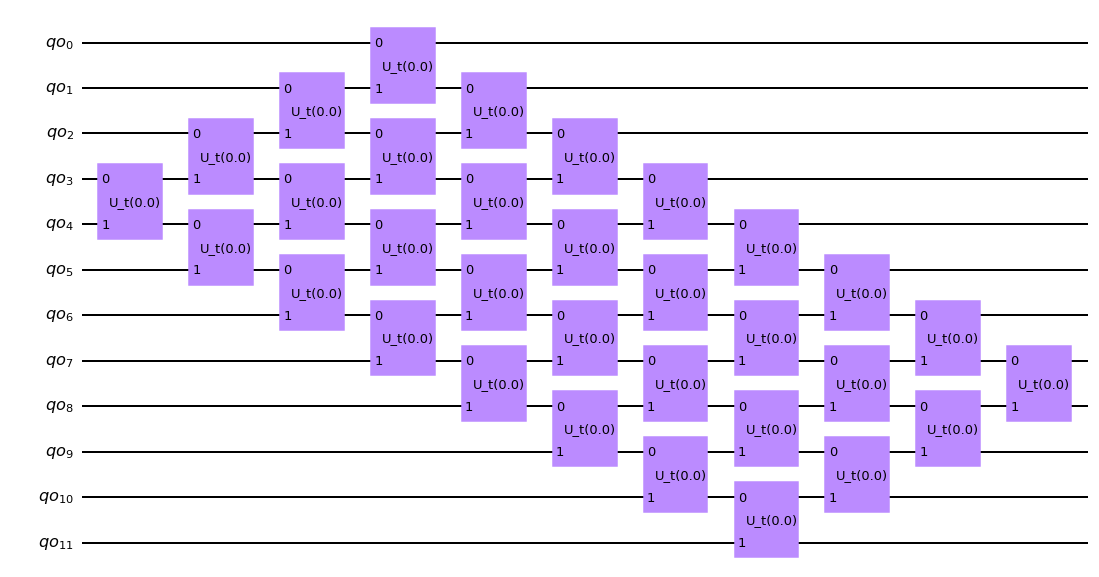

In [12]:
nr_o=num_spin_orbitals
nr_e=num_particles
nr_par=(nr_o-nr_e)*nr_e
theta=np.zeros(nr_par)
print(theta)
qo=QuantumRegister(nr_o,'qo')
ansatz = QuantumCircuit(qo)
ansatz_cell(ansatz,qo,nr_o, nr_e,theta)
ansatz.draw('mpl')

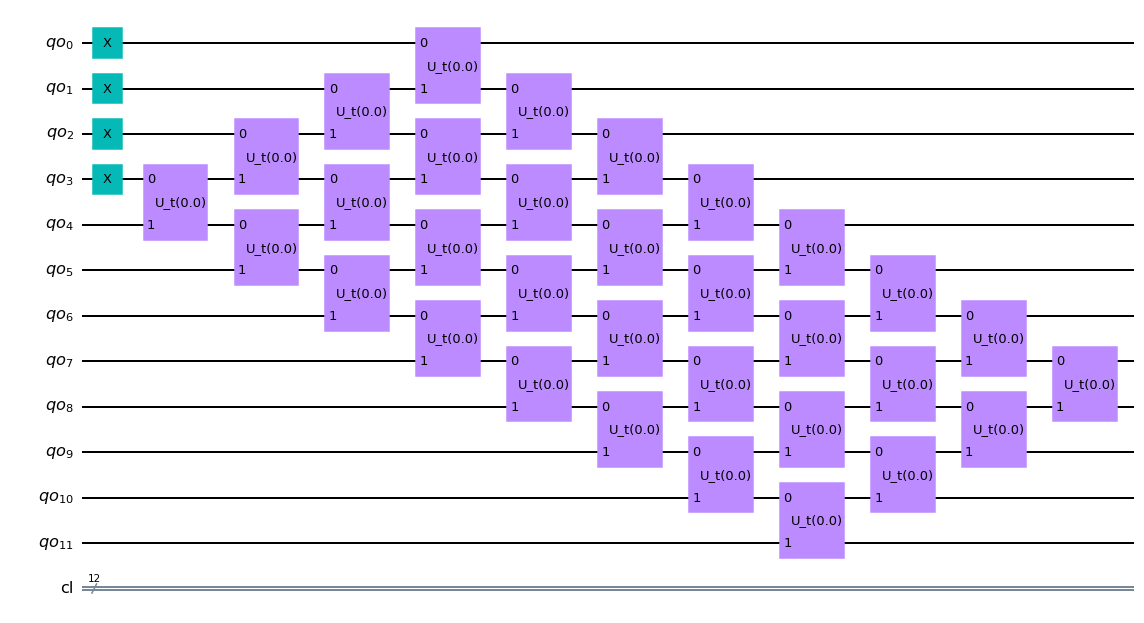

In [14]:
circ=var_circ(nr_o,nr_e,theta)
circ.draw('mpl')
print(value(weight,pauli,circ,backend))

In [17]:
def VQE(weight,pauli,nr_o,nr_e,backend):
    
    theta=np.zeros(nr_par)
    optim=minimize(cost, 
                   theta,args=(weight,pauli,nr_o,nr_e,backend),
                   method='COBYLA', 
                   options={'rhobeg': 1.0, 'maxiter': 2000, 'disp': True, 'catol': 0.0002})
    
    circ=var_circ(nr_o,nr_e,optim.x)
    eigval=value(weight,pauli,circ,backend)
    
    return eigval

In [ ]:
VQEresult=np.real(VQE(weight,pauli,nr_o,nr_e,backend))

/Users/voicutu/opt/anaconda3/envs/venvCQ/lib/python3.8/site-packages/scipy/optimize/cobyla.py:250: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = _cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,


In [ ]:
print("Result: ",VQEresult)
print("Reference:",Exact_solver(qubitOp))